---

## Библиотеки и пакеты

---

In [1]:
using SciMLBase

using DiffEqCallbacks
using DifferentialEquations

using DynamicalSystems

using StaticArrays

using Plots

using Latexify
using LaTeXStrings

using ProgressMeter

In [2]:
using JLD

In [3]:
using BenchmarkTools

In [4]:
using ColorSchemes

In [5]:
include("Utils\\Visualization_Utils.jl"); using .Visualization_Utils
include("Utils\\Computation_Utils.jl"); using .Computation_Utils
include("Utils\\CallBack_Utils.jl"); using .CallBack_Utils
include("ODEs\\BS_ODE.jl"); using .BS_ODE
include("ODEs\\BS_Transformed_ODE.jl"); using .BS_Transformed_ODE
include(raw"Utils\Bifurcation_Utils.jl")
include(raw"Utils\Inheritance_Utils.jl")

In [6]:
#md = MatcontData("matcont_data/new_diagram")
#md = MatcontData("matcont_data/diagram")

---

### Вспомогательные функции

---

In [7]:
function get_sol_endstate(ODE, ic, time_span, P, callback; alg = DP8(), kwargs...)
    prob_julia = ODEProblem(ODE, ic, time_span, P)
    sol = solve(prob_julia, alg; callback, kwargs...)#, save_everystep = false

    if sol.retcode == ReturnCode.Success
        return sol
    else
        return nothing
    end
end

get_sol_endstate (generic function with 1 method)

In [8]:
function positive_λ(λ; border=1e-4)
    if abs(λ[1]) < border || λ[1] < 0.0 # Первый эл-т спектра нулевой
        return 0
    elseif λ[1] > border # Первый эл-т спектра больше нуля
        if abs(λ[2]) < border || λ[2] < 0.0 # Второй эл-т спектра нулевой
            return 1
        elseif λ[2] > border # Второй эл-т спектра больше нуля
            return 2
        end
    end
    return NaN
end

positive_λ (generic function with 1 method)

In [9]:
#test_ic = SVector{6}(rand(6))
#@benchmark w(test_ic, P, 0.0)

---

## Параметры карты

---

In [53]:
len = 50

ODE = BS_Log

a4 = pi
a2 = pi/2
r = 0.016850701746869687
K = 0.06
Eps = 0.05206157664979711

#A = -0.05977203237457928
#B = -0.06740280698747875
#C = 0.0
#Eps = 0.05206157664979711

P = bick2abc([K, r, a2, a4, Eps])

ic = SA[
1.7608965303167805
-1.836315684786463
-1.9805236875796837
 0.8761469015427517
-2.8839535214986975
 1.0588719997112572
 ]

K_border = (0.059, 0.0625)
Eps_border = (0.0495, 0.0545)

icpm = ICPMEsh(K_border[1], K_border[2], Eps_border[1], Eps_border[2], (K, Eps, ic), len)

K_ls = [a[1] for a in icpm.p_mesh[:, 1]]
Eps_ls = [a[2] for a in icpm.p_mesh[1, :]];

In [81]:
len = 500

Eps = 0.05395
K = 0.0606

P = bick2abc([K, r, a2, a4, Eps])

ic = SA[
    1.4034182385112066
    -2.0632279264705256
     0.17700678644288576
     0.2785297674059468
    -2.1817899464283053
    -0.9804754775408616
 ]

K_ls = range(0.060075, 0.061125, length = len)
Eps_ls = range(0.0532, 0.0547, length = len)

icpm = ICPMEsh(K_ls[begin], K_ls[end], Eps_ls[begin], Eps_ls[end], (K, Eps, ic), len)

K_ls = [a[1] for a in icpm.p_mesh[:, 1]]
Eps_ls = [a[2] for a in icpm.p_mesh[1, :]];

In [11]:
## Numerical parameters ##
time_span = 20_000
trans_time = 5_000.0

#alg = DP8()
#alg = RK4()
alg = Tsit5()
#alg = AutoVern9(Rodas4())
#alg = TRBDF2(autodiff=false)
#alg = Vern7()
abstol = 1e-6
reltol = 1e-6
dtmax = 5e-1
dtmin = 1e-20
maxiters = 1e10
saveat = 10.0

kwargs = Dict(:dtmax => dtmax, :dtmin => dtmin, :abstol => abstol, :reltol => reltol, :maxiters => maxiters, :saveat => saveat);
diffeq = (dtmax = dtmax, dtmin = dtmin, alg = alg, abstol = abstol, reltol = reltol, maxiters = maxiters)

## Callback function ##
condition(u, t, integrator) = any(x -> (x < -20.0 || x > 20.0), u) - 0.5
affect!(integrator) = terminate!(integrator)
callback = DiffEqCallbacks.ContinuousCallback(condition, affect!)

ContinuousCallback{typeof(condition), typeof(affect!), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}(condition, affect!, affect!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, nothing, SciMLBase.LeftRootFind, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0, 1//100)

In [26]:
prob_julia = ODEProblem(ODE, ic, time_span, P)
sol = solve(prob_julia, alg; callback, kwargs...); sol.retcode

ReturnCode.Success = 1

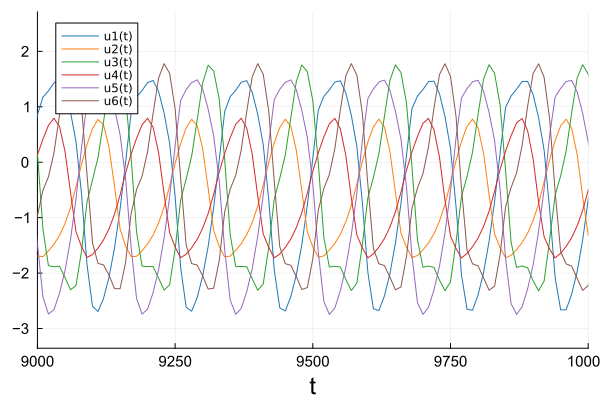

In [31]:
plot(sol, xlims = (9000, 10000))

---

## Разное

---

In [ ]:
bifcurves!(md, Pair("Eps", "A"), color = "blue", size = (800, 600), xlims = (Eps_ls[1], Eps_ls[end]), ylims = (A_ls[1], A_ls[end]), alpha = 0.5)

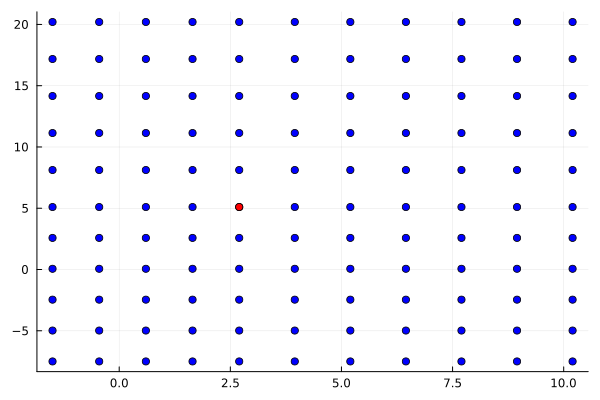

In [255]:
a, i = get_ls_ip(-1.5, 10.2, 2.7, 10)
b, j = get_ls_ip(-7.5, 20.2, 5.1, 10)

x = repeat(a, 1, 11)
y = transpose(repeat(b, 1, 11))

scatter(x, y, legend = false, color = :blue)
scatter!([a[i]], [b[j]], legend = false, color = :red)

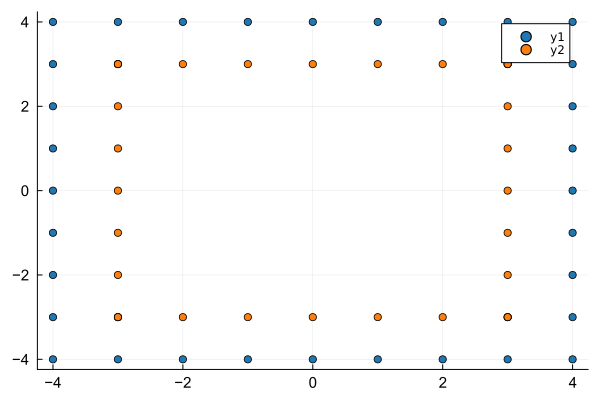

In [364]:
pts = get_rad_idx(4)
prev_pts = [get_prev_idx(p[1], p[2]) for p in pts]

scatter([x[1] for x in pts], [x[2] for x in pts])
scatter!([x[1] for x in prev_pts], [x[2] for x in prev_pts])

---

## Супер протяжка по параметрам

---

In [82]:
λs = Matrix{Vector{Float64}}(undef, size(icpm.p_mesh))
max_vals = Matrix{Vector{Float64}}(undef, size(icpm.p_mesh))
min_vals = Matrix{Vector{Float64}}(undef, size(icpm.p_mesh))

i_shift, j_shift = icpm.idx0

@showprogress "Computing..." for radius in 0:get_radius(icpm)
    Threads.@threads for (i, j) in get_rad_idx(radius)
        cur_icp = icpm[i, j]
        if !isnothing(cur_icp)
            cur_p, cur_ic = cur_icp
            #P = [cur_p[1], B, C, cur_p[2]]
            P = bick2abc([cur_p[1], r, a2, a4, cur_p[2]])
            
            endstate_sol = get_sol_endstate(ODE, cur_ic, 30_000, P, callback; alg, kwargs...)
            if !isnothing(endstate_sol)
                lvDs = CoupledODEs(ODE, cur_ic, P; diffeq)
                tanDs = TangentDynamicalSystem(lvDs)

                λs[i_shift + i, j_shift + j] = lyapunovspectrum(tanDs, time_span; Ttr = trans_time);
                max_vals[i_shift + i, j_shift + j] = [maximum(endstate_sol[i, :]) for i in 1:6]
                min_vals[i_shift + i, j_shift + j] = [minimum(endstate_sol[i, :]) for i in 1:6]

                icpm[i, j] = endstate_sol[:, end]
            else
                λs[i_shift + i, j_shift + j] = fill(NaN, 6)
                max_vals[i_shift + i, j_shift + j] = fill(NaN, 6)
                min_vals[i_shift + i, j_shift + j] = fill(NaN, 6)
                icpm[i, j] = icpm[0, 0][2]
            end
        end
    end
end

Computing...  30%|████████████                           |  ETA: 0:43:17┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\artyo\.julia\packages\SciMLBase\KcGs1\src\integrator_interface.jl:606
Computing...  31%|████████████                           |  ETA: 0:43:37┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\artyo\.julia\packages\SciMLBase\KcGs1\src\integrator_interface.jl:606
Computing...  31%|█████████████                          |  ETA: 0:43:57┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\artyo\.julia\packages\SciMLBase\KcGs1\src\integrator_interface.jl:606
Computing...  31%|█████████████                          |  ETA: 0:44:15┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\artyo\.julia\packages\SciMLBase\KcGs1\src\integrator_interface.jl:606
Computing...  32%|█████████████                          |  ETA: 0:44:32┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\artyo\.julia\packages\SciMLBase\KcG

In [92]:
save("./mapdata_500x500_zoom_1.jld",
"lambdas", λs,
"max_vals", max_vals,
"min_vals", min_vals,
"ics", icpm.ics,
"K", K,
"r", r,
"a2", a2,
"a4", a4,
"K_border", K_border,
"Eps_border", Eps_border,
"len", len)

In [24]:
icpm.ics[92, 24]

6-element SVector{6, Float64} with indices SOneTo(6):
  1.4034182385112066
 -2.0632279264705256
  0.17700678644288576
  0.2785297674059468
 -2.1817899464283053
 -0.9804754775408616

In [60]:
function get_new_scaled_borders(K_new, Eps_new, K_border, Eps_border, scale=0.3)
    K_radius = scale*(K_border[2] - K_border[1]) / 2.0
    Eps_radius = scale*(Eps_border[2] - Eps_border[1]) / 2.0
    
    return ([Eps_new-Eps_radius, Eps_new+Eps_radius], [K_new-K_radius, K_new+K_radius])
end

get_new_scaled_borders (generic function with 2 methods)

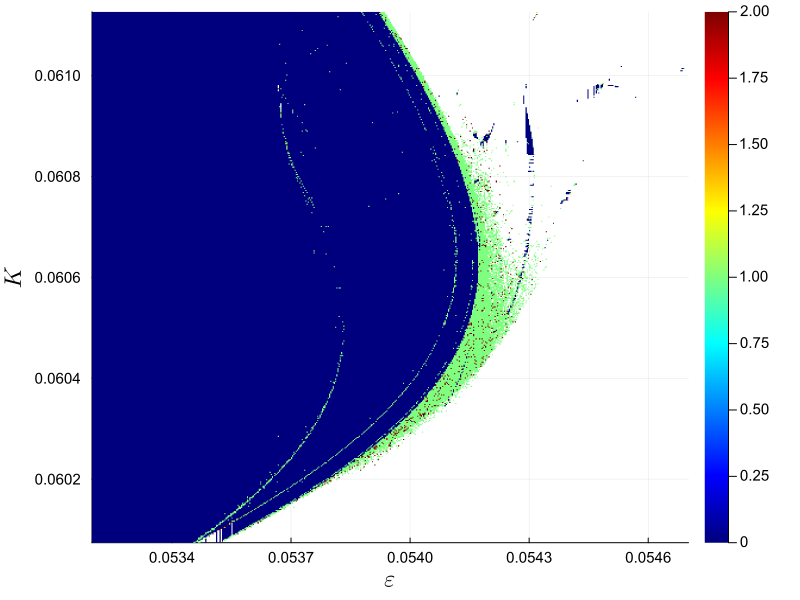

In [89]:
hm = heatmap(Eps_ls, K_ls, [positive_λ(λ; border=8e-5) for λ in λs], right_margin=(6.0, :mm), size = (800, 600), c=:jet, xguide=L"ε", yguide=L"K")

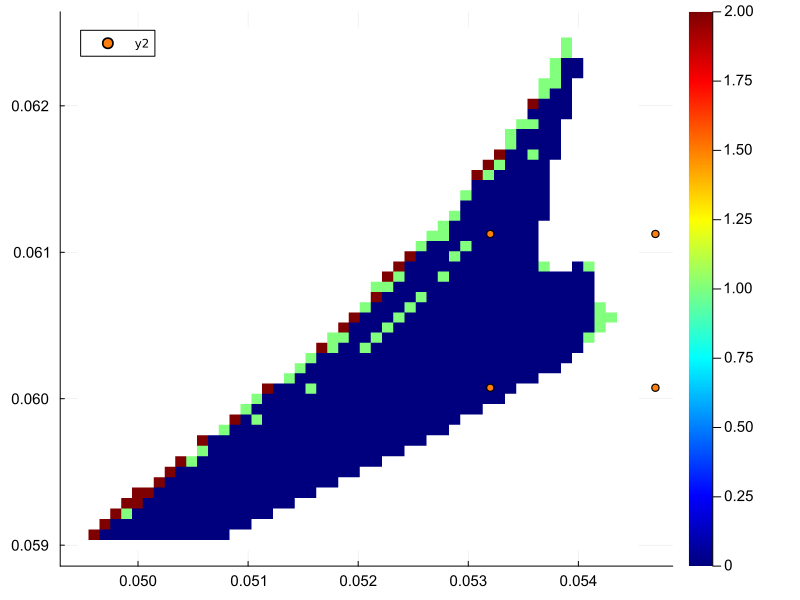

In [61]:
hm = heatmap(Eps_ls, K_ls, [positive_λ(λ; border=1e-4) for λ in λs], right_margin=(10.0, :mm), size = (800, 600), c=:jet) #,  clims = (-0.0005, 0.0005), , c = :seismic , c=mypalette
#bifcurves!(md, Pair("Eps", "A"), color = "blue", xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5)
#scatter!([Eps_ls[92]], [K_ls[42]], lab=L"Eps=%$Eps ~K=%$K", xguide=L"ε", yguide=L"K")

Eps_new_border, K_new_border = get_new_scaled_borders(0.0606, 0.05395, K_border, Eps_border)

scatter!([Eps_new_border[1], Eps_new_border[1], Eps_new_border[2], Eps_new_border[2]], [K_new_border[1], K_new_border[2], K_new_border[1], K_new_border[2]])

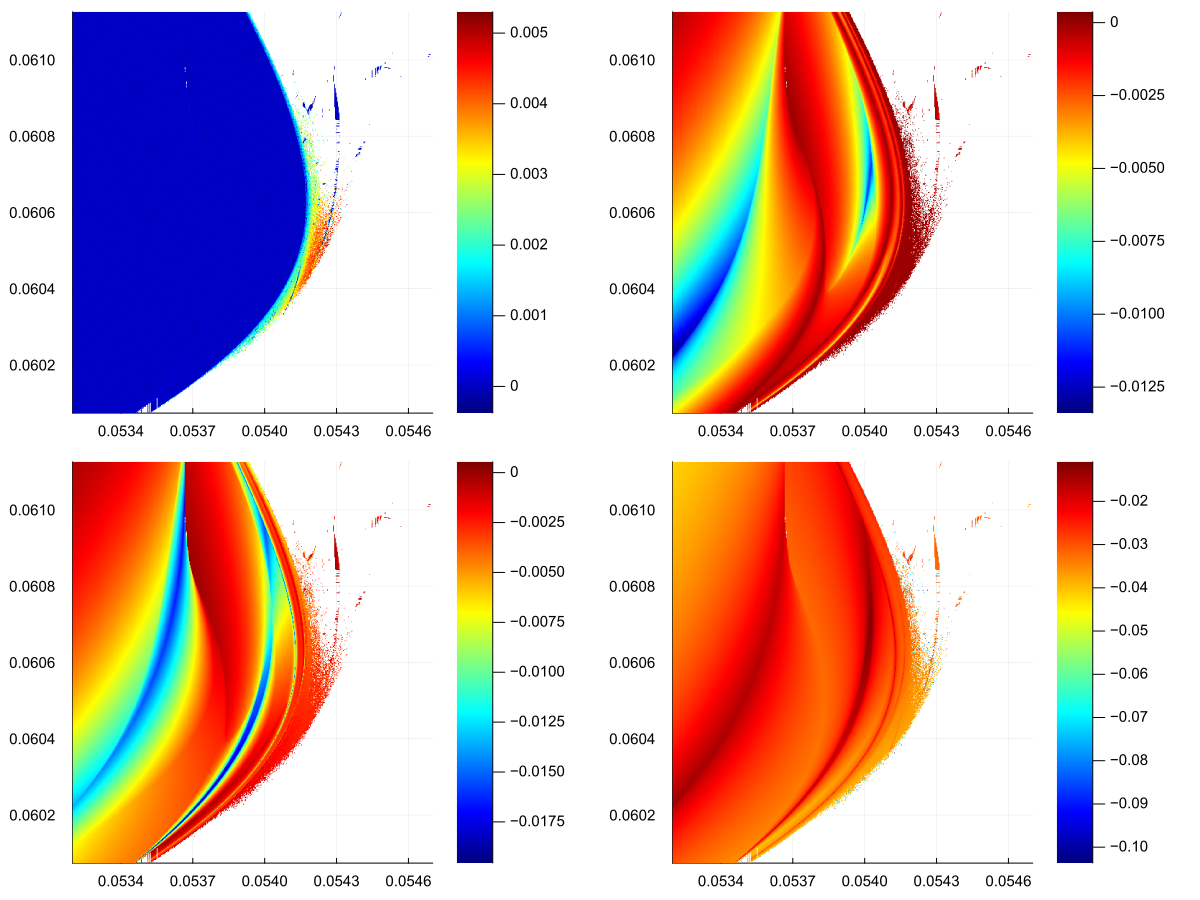

In [91]:
plot(
heatmap(Eps_ls, K_ls, [λ[1] for λ in λs], right_margin=(10.0, :mm), size = (800, 600), c=:jet),
heatmap(Eps_ls, K_ls, [λ[2] for λ in λs], right_margin=(10.0, :mm), size = (800, 600), c=:jet),
heatmap(Eps_ls, K_ls, [λ[3] for λ in λs], right_margin=(10.0, :mm), size = (800, 600), c=:jet),
heatmap(Eps_ls, K_ls, [λ[4] for λ in λs], right_margin=(10.0, :mm), size = (800, 600), c=:jet),
layout = (2, 2),
size = (1200, 900)
)

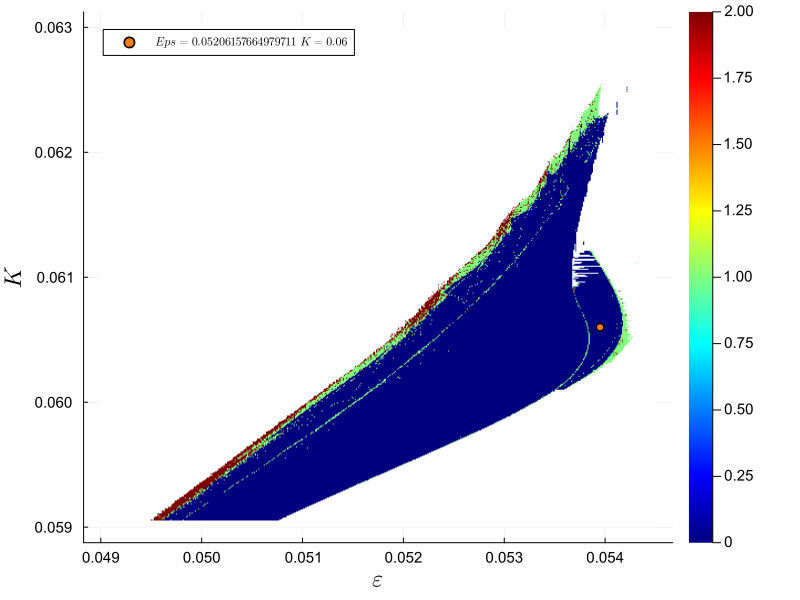

In [92]:
hm = heatmap(Eps_ls, A_ls, [positive_λ(λ; border=1e-4) for λ in λs], right_margin=(10.0, :mm), size = (800, 600), c=:jet) #,  clims = (-0.0005, 0.0005), , c = :seismic , c=mypalette
#bifcurves!(md, Pair("Eps", "A"), color = "blue", xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5)
scatter!([0.05395], [0.0606], lab=L"Eps=%$Eps ~K=%$K", xguide=L"ε", yguide=L"K")

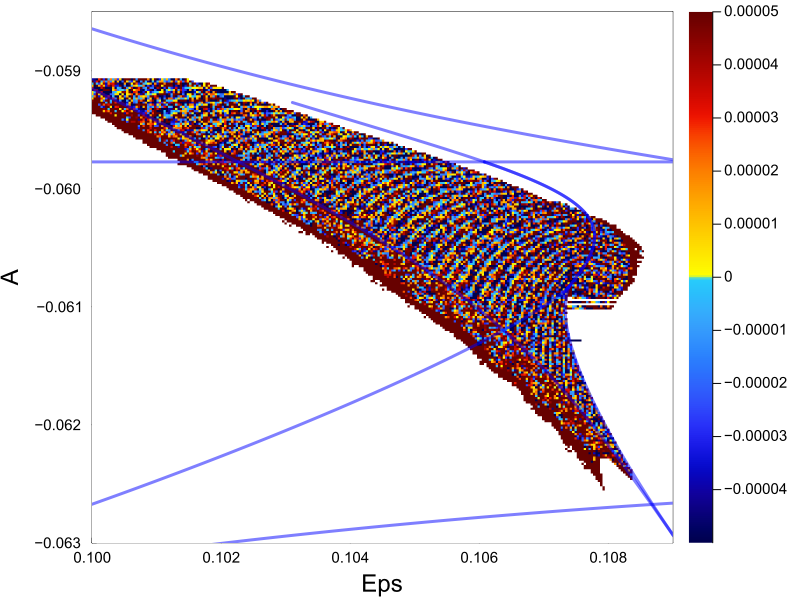

In [190]:
hm = heatmap(Eps_ls, A_ls, [maximum(λ) for λ in λs], right_margin=(10.0, :mm), clims = (-0.00005, 0.00005), c=mypalette) #,  clims = (-0.0005, 0.0005), , c = :seismic
bifcurves!(md, Pair("Eps", "A"), color = "blue", size = (800, 600), xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5)

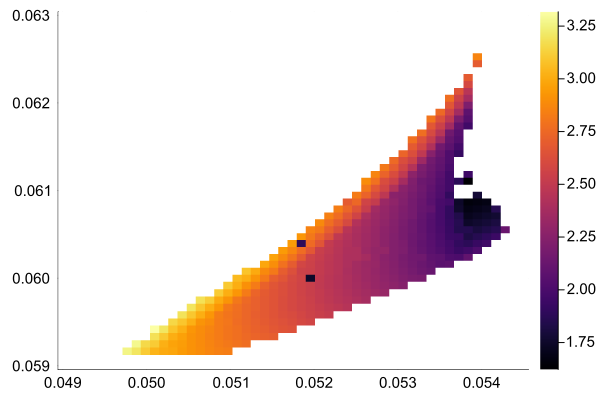

In [76]:
hm = heatmap(Eps_ls, A_ls, [maximum(mv) for mv in max_vals])
#bifcurves!(md, Pair("Eps", "A"), color = "blue", size = (800, 600), xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5)

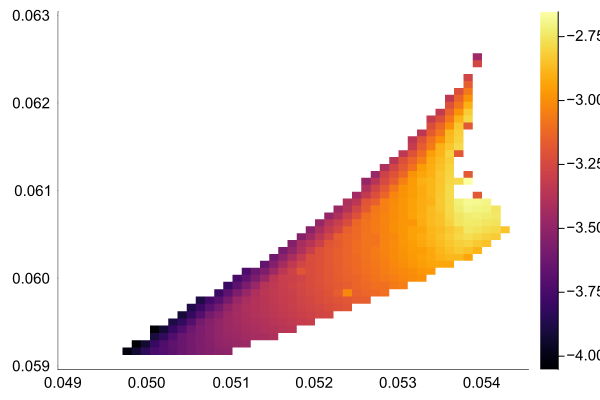

In [77]:
hm = heatmap(Eps_ls, A_ls, [minimum(mv) for mv in min_vals])
#bifcurves!(md, Pair("Eps", "A"), color = "blue", size = (800, 600), xlims = (minimum(Eps_ls), maximum(Eps_ls)), ylims = (minimum(A_ls), maximum(A_ls)), alpha = 0.5)

In [19]:
p = plot()

for radius in 0:get_radius(icpm)
    for (i, j) in get_rad_idx(radius)
        cur_icp = icpm[i, j]
        if !isnothing(cur_icp)
            if !isnan(λs[i_shift + i, j_shift + j][1])

                p_i, p_j = get_prev_idx(i, j)
                plot!([p_j, j], [p_i, i], color=radius)
                scatter!([j], [i], color=radius, ms = 2.0)
            end
        end
    end
end

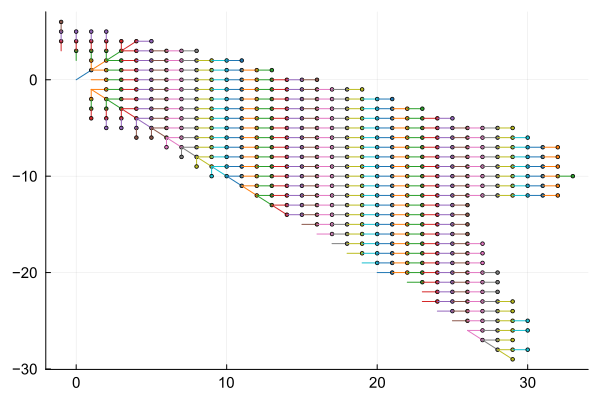

In [20]:
plot(p, legend = false)

In [111]:
#data = load(raw"data\mapdata_1000x1000.jld", "lambdas")

data_file = raw"data\mapdata_500x500_2.jld"
λs = load(data_file, "lambdas")
#max_vals = load(data_file, "max_vals")
#min_vals = load(data_file, "min_vals")
icpm = load(data_file, "icpm")

: 

: 